# Лабораторная работа № 6.

## Сети Кохонена

Целью работы является исследование свойств слоя Кохонена, карты Кохонена, а также сетей векторного квантования, обучаемых с учителем, алгоритмов обучения, а также применение сетей в задачах кластеризации и классификации.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from tqdm import tqdm, trange

### Самоорганизующаяся карта Кохонена

In [2]:
MIN_LR = 1e-2
MAX_LR = 1.0


class SOM:
    def __init__(self, n, m, dim):
        self.n = n
        self.m = m
        self.dim = dim

        self.nodes = np.random.rand(n * m, dim)
        self.xy = np.array([(i / m, i % m) for i in range(n * m)])

        self.r = max(n, m) / 2
        self.lr = MAX_LR

    def update_nodes(self, sample, r, lr):
        dist = np.sum((self.nodes - sample) ** 2, 1)
        node_id = np.argmin(dist)
        node_c = self.nodes[node_id]
        for i, node_xy in enumerate(self.xy):
            d = np.sum((self.xy[node_id] - node_xy) ** 2, 0) ** 0.5
            if d <= r:
                influence = np.exp(-d / (2 * r))
                self.nodes[i] += lr * influence * (sample - self.nodes[i])

    def fit(self, data, r=None, lr=None, epochs=100):
        if r == None:
            r = self.r
        if lr == None:
            lr = self.lr
        lr = max(MIN_LR, min(lr, MAX_LR))

        lr_decay = 1 / epochs
        r_decay = np.log(r) / epochs

        h = {"nodes": [self.get_nodes()]}

        n = data.shape[0]
        indices = np.arange(n)
        for epoch in trange(1, epochs + 1, desc="Training SOM", ascii=True):
            np.random.shuffle(indices)
            for elem in indices:
                self.update_nodes(data[elem], r, lr)

            lr = max(MIN_LR, self.lr * np.exp(-epoch * lr_decay))
            r = self.r * np.exp(-epoch * r_decay)
            h["nodes"].append(self.get_nodes())
        return h

    def get_nodes(self, reshape=True):
        nodes = np.copy(self.nodes)
        if reshape:
            return nodes.reshape(self.n, self.m, self.dim)
        else:
            return nodes

    def load_2d(self, min_x=0, max_x=1, min_y=0, max_y=1):
        hx = (max_x - min_x) / (self.n - 1) if self.n > 1 else 0.0
        hy = (max_y - min_y) / (self.m - 1) if self.m > 1 else 0.0
        for i in range(self.n):
            for j in range(self.m):
                self.nodes[i * self.m + j] = np.array([min_x + i * hx, min_y + j * hy])

Вспомогательные функции

In [3]:
def get_xy(points):
    res_x = []
    res_y = []
    for x, y in points:
        res_x.append(x)
        res_y.append(y)
    return (np.array(res_x), np.array(res_y))

In [4]:
PLOT_SIZE = 5
NET_COLOR = "tab:orange"
POINTS_COLOR = "tab:blue"


def plot_history_2d(history, n=3, m=3):
    h = history["nodes"]
    epochs = len(h)
    nm = n * m - 1
    indeces = [(epochs * i) // (nm) for i in range(nm)]
    indeces.append(epochs - 1)
    data = [[None for _ in range(m)] for _ in range(n)]
    titles = [[None for _ in range(m)] for _ in range(n)]
    for i in range(n):
        for j in range(m):
            ind = indeces[i * m + j]
            data[i][j] = np.copy(h[ind]).reshape(N * M, 2)
            titles[i][j] = "Эпоха " + str(ind)
    titles[0][0] = "Изначальные веса"
    fig, axes = plt.subplots(n, m, figsize=(PLOT_SIZE * m, PLOT_SIZE * n))
    for i in range(n):
        for j in range(m):
            ax = axes[i, j]
            train_x, train_y = get_xy(points)
            ax.scatter(train_x, train_y, color=POINTS_COLOR)
            nodes_x, nodes_y = get_xy(data[i][j])
            ax.scatter(nodes_x, nodes_y, color=NET_COLOR)
            ind = indeces[i * m + j]
            nodes_NM = h[ind]
            for ii in range(N):
                for jj in range(1, M):
                    ln_x, ln_y = get_xy([nodes_NM[ii][jj - 1], nodes_NM[ii][jj]])
                    ax.plot(ln_x, ln_y, color=NET_COLOR)
            for ii in range(1, N):
                for jj in range(M):
                    ln_x, ln_y = get_xy([nodes_NM[ii - 1][jj], nodes_NM[ii][jj]])
                    ax.plot(ln_x, ln_y, color=NET_COLOR)
            ax.set_title(titles[i][j])
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_aspect(1)
    plt.show()

Обучающее множество точек

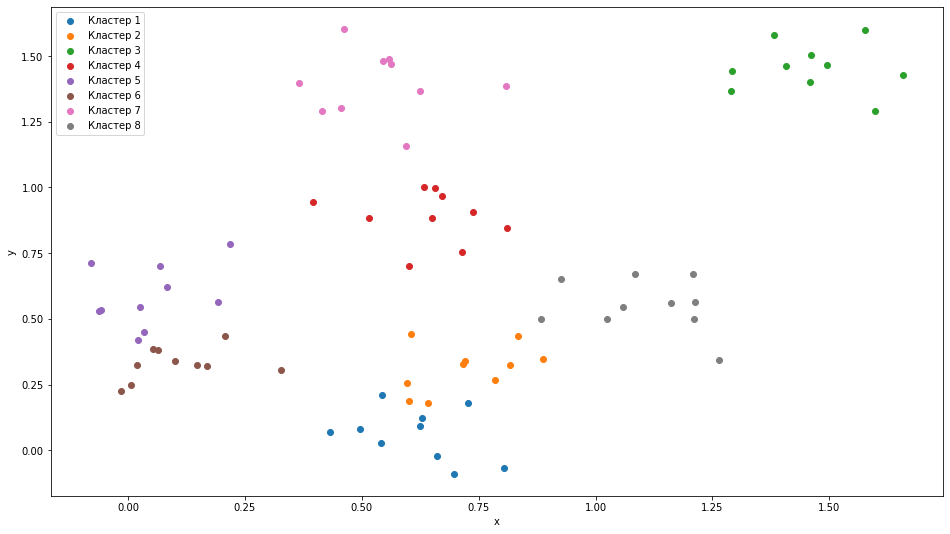

In [5]:
MAX_CORD = 1.5
DEVIATION = 0.1

clusters = 8
points_per_claster = 10
points, classes = make_blobs(
    clusters * points_per_claster,
    centers=clusters,
    center_box=(0, MAX_CORD),
    cluster_std=DEVIATION,
)

figure = plt.figure(figsize=(16, 9))
ax = figure.add_subplot(111)

for cl in range(clusters):
    cl_points = []
    for i, elem in enumerate(points):
        if classes[i] == cl:
            cl_points.append(elem)
    x, y = get_xy(cl_points)
    plt.scatter(x, y, label="Кластер " + str(cl + 1))

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Кластеризация точек

In [6]:
N = 5
M = 5

koh2d = SOM(N, M, 2)
koh2d.load_2d(min_x=0.5, max_x=1.0, min_y=0.5, max_y=1.0)
h = koh2d.fit(points, epochs=50)

Training SOM: 100%|###########################################################################################################################################| 50/50 [00:00<00:00, 69.49it/s]


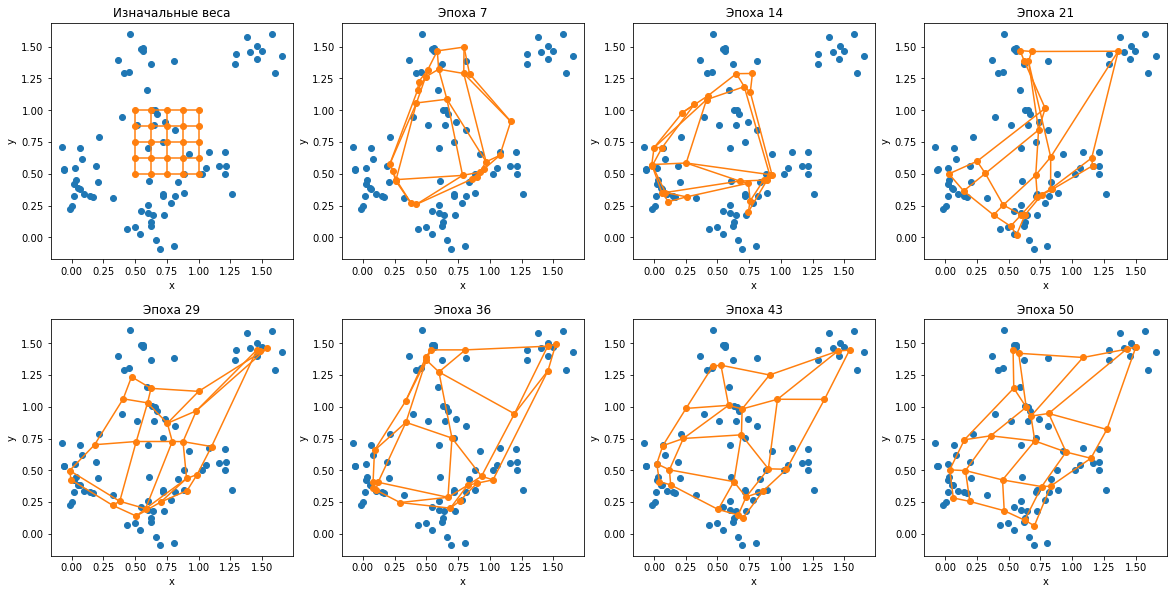

In [7]:
plot_history_2d(h, 2, 4)

### Задача коммивояжера

In [8]:
N = 80
M = 1

koh2d = SOM(N, M, 2)
koh2d.load_2d(min_x=0.5, max_x=1.0, min_y=0.5, max_y=1.0)
h = koh2d.fit(points, epochs=50)

Training SOM: 100%|###########################################################################################################################################| 50/50 [00:01<00:00, 25.96it/s]


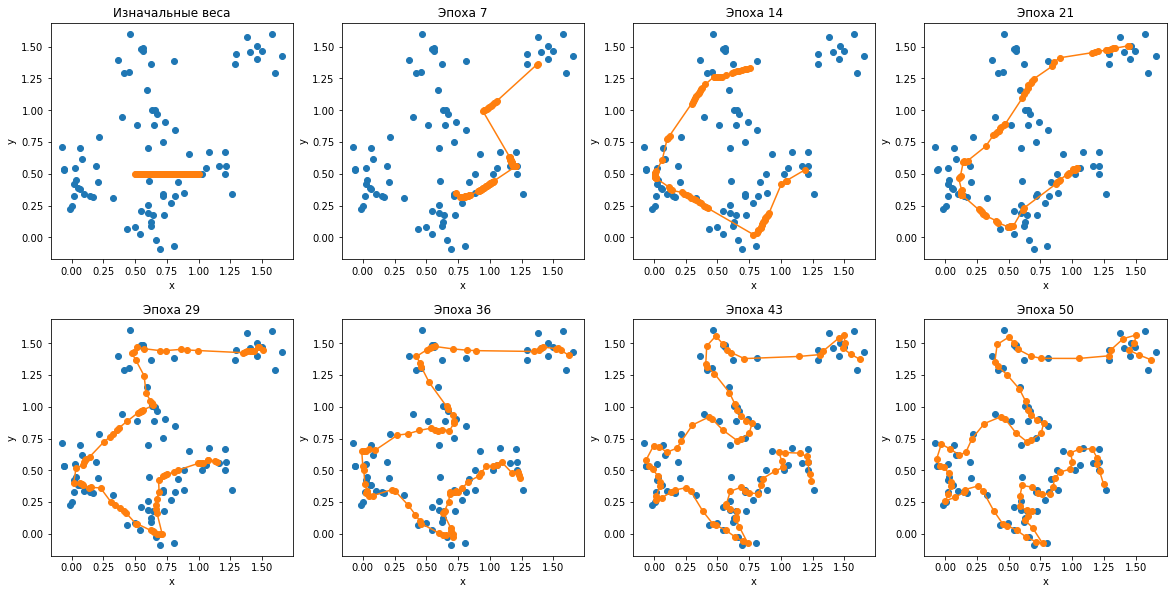

In [9]:
plot_history_2d(h, 2, 4)

### Кластеризация изображений

Функции для визуализации

In [10]:
IMG_SIZE = 3


def display_images(data, n=2, m=2, titles=None):
    n = max(2, n)
    m = max(2, m)
    fig, ax = plt.subplots(n, m, figsize=(IMG_SIZE * m, IMG_SIZE * n))
    for i in range(n):
        for j in range(m):
            img = data[i][j]
            ax[i, j].imshow(img)
            ax[i, j].axis("off")
            if titles != None:
                ax[i, j].set_title(titles[i][j])
    plt.tight_layout()
    plt.show()


def plot_history_rgb(history, n=3, m=3):
    h = history["nodes"]
    epochs = len(h)
    nm = n * m - 1
    indeces = [(epochs * i) // (nm) for i in range(nm)]
    indeces.append(epochs - 1)
    imgs = [[None for _ in range(m)] for _ in range(n)]
    titles = [[None for _ in range(m)] for _ in range(n)]
    for i in range(n):
        for j in range(m):
            ind = indeces[i * m + j]
            imgs[i][j] = h[ind]
            titles[i][j] = "Эпоха " + str(ind)
    titles[0][0] = "Изначальные веса"
    display_images(imgs, n, m, titles)

3 цвета

In [11]:
koh3 = SOM(48, 64, 3)

rgb3 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

h3 = koh3.fit(rgb3, epochs=100)

Training SOM: 100%|#########################################################################################################################################| 100/100 [00:04<00:00, 20.93it/s]


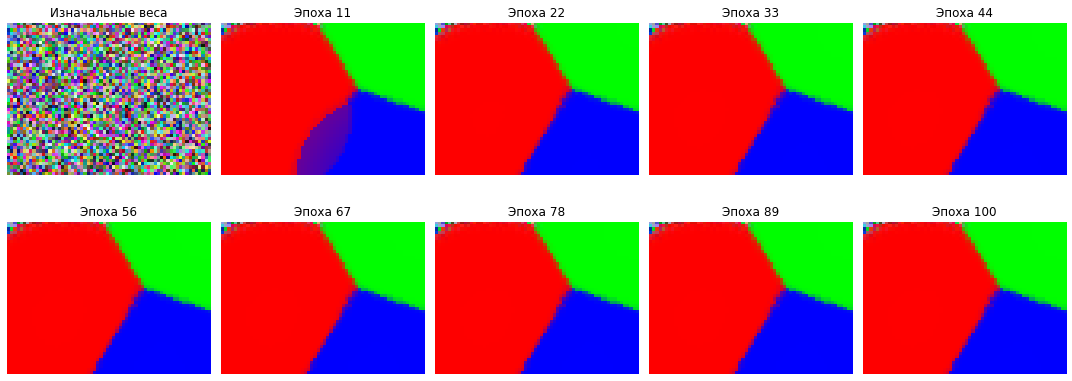

In [12]:
plot_history_rgb(h3, 2, 5)

6 цветов

In [13]:
koh6 = SOM(48, 64, 3)

rgb6 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 1], [0, 1, 1], [1, 1, 0]])

h6 = koh6.fit(rgb6, epochs=100)

Training SOM: 100%|#########################################################################################################################################| 100/100 [00:09<00:00, 10.28it/s]


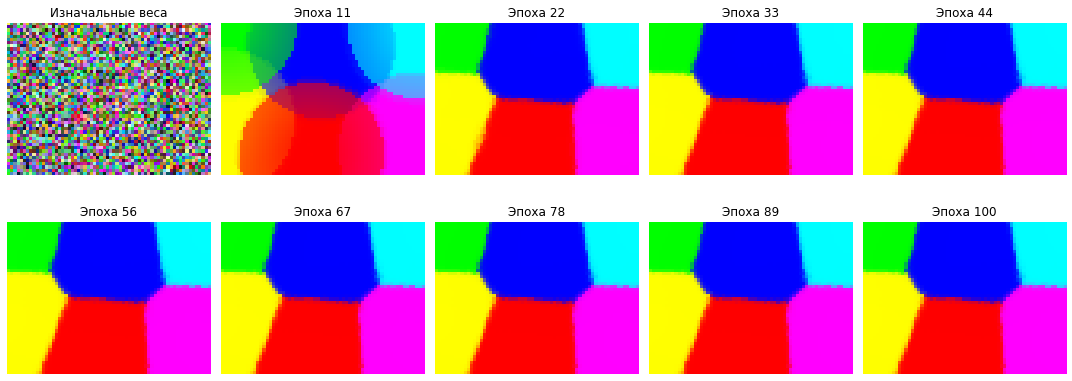

In [14]:
plot_history_rgb(h6, 2, 5)

### Вывод

В ходе выполнения лабораторной работы я ознакомился с самоорганизующейся картой Кохонена, реализовал её для кластеризации точек на плоскости и кластеризации изображения.